In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import SimpleITK as sitk
import nibabel as nib
import glob
from google.colab import files
import shutil

In [1]:
def unzip_to_folder(zip_path):
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    os.makedirs(folder_name, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print(f"Unzipped {zip_path} → {folder_name}/")
    return folder_name

In [2]:
unzip_to_folder("/content/Final_Dataset.zip")

✔ Unzipped /content/Final_Dataset.zip → Final_Dataset/


'Final_Dataset'

In [3]:
def visualize_subject(subject_id, data_dir="Data", label_dir="Label"):

    mri_path = os.path.join(data_dir, f"mri_{subject_id}.mgz")
    label_path = os.path.join(label_dir, f"{subject_id}.nii")


    mri_img = nib.load(mri_path).get_fdata()
    label_img = nib.load(label_path).get_fdata()

    # Axial slice
    z_mid = mri_img.shape[2] // 2
    mri_slice = mri_img[:, :, z_mid]
    label_slice = label_img[:, :, z_mid]

    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(mri_slice), cmap="gray")
    plt.imshow(np.rot90(label_slice), cmap="gray", alpha=0.4)  # overlay
    plt.axis("off")
    plt.title(f"Subject {subject_id} - Axial View")
    plt.show()


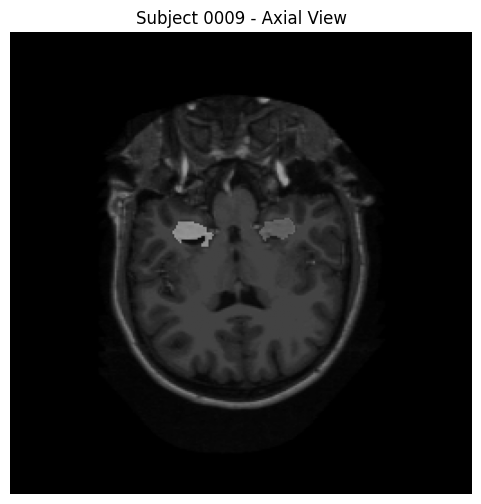

In [5]:
visualize_subject("0009", data_dir="/content/Final_Dataset/Final_Dataset/Data", label_dir="/content/Final_Dataset/Final_Dataset/Label")

In [6]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 9.1 MB/s eta 0:00:00


In [7]:
def n4_bias_correction(input_path, output_path):

    img = sitk.ReadImage(input_path)
    img = sitk.Cast(img, sitk.sitkFloat32)

    # Create mask using Otsu (brain foreground)
    mask_img = sitk.OtsuThreshold(img, 0, 1, 200)

    # Run N4 Bias Correction
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    img_corrected = corrector.Execute(img, mask_img)

    sitk.WriteImage(img_corrected, output_path)
    print(f"Saved N4 corrected image → {output_path}")


In [52]:
img = nib.load("/content/Data/mri_0001.mgz")
nib.save(img, "mri_0001.nii")

In [ ]:
n4_bias_correction("mri_0001.nii", "Data_corrected/mri_0001_n4.nii")

In [8]:
def n4_bias_correction_fast(input_path, output_path):

    img = sitk.ReadImage(input_path, sitk.sitkFloat32)

    # Create brain mask (Otsu thresholding)
    mask_img = sitk.OtsuThreshold(img, 0, 1, 200)

    # Downsample for bias estimation
    shrink_factor = 2
    img_down = sitk.Shrink(img, [shrink_factor]*3)
    mask_down = sitk.Shrink(mask_img, [shrink_factor]*3)

    # N4 with fewer iterations
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50, 50, 30])

    corrected_down = corrector.Execute(img_down, mask_down)

    # Apply estimated bias field to full-res
    log_bias_field = corrector.GetLogBiasFieldAsImage(img)
    bias_field = sitk.Exp(log_bias_field)
    img_corrected = img / bias_field

    sitk.WriteImage(img_corrected, output_path)
    print(f"Saved fast N4 corrected image → {output_path}")


def batch_n4_correction(data_dir="Data", output_dir="Data_N4"):

    os.makedirs(output_dir, exist_ok=True)

    mri_files = sorted(glob.glob(os.path.join(data_dir, "mri_*.mgz")) +
                       glob.glob(os.path.join(data_dir, "mri_*.nii")))

    for mri_path in mri_files:
        subj_id = os.path.basename(mri_path).split(".")[0]
        out_path = os.path.join(output_dir, f"{subj_id}.nii")

        n4_bias_correction_fast(mri_path, out_path)




In [9]:
import nibabel as nib
import os
import glob

def convert_mgz_to_nii(input_dir="Data", output_dir="Data_nii"):

    os.makedirs(output_dir, exist_ok=True)

    mgz_files = sorted(glob.glob(os.path.join(input_dir, "mri_*.mgz")))

    for mgz_path in mgz_files:
        subj_id = os.path.basename(mgz_path).replace(".mgz", "")
        out_path = os.path.join(output_dir, f"{subj_id}.nii")

        img = nib.load(mgz_path)
        nib.save(img, out_path)

        print(f"Converted {mgz_path} → {out_path}")


convert_mgz_to_nii("/content/Final_Dataset/Final_Dataset/Data", "Data_nii")


✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0009.mgz → Data_nii/mri_0009.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0010.mgz → Data_nii/mri_0010.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0013.mgz → Data_nii/mri_0013.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0032.mgz → Data_nii/mri_0032.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0037.mgz → Data_nii/mri_0037.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0041.mgz → Data_nii/mri_0041.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0043.mgz → Data_nii/mri_0043.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0045.mgz → Data_nii/mri_0045.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0046.mgz → Data_nii/mri_0046.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0052.mgz → Data_nii/mri_0052.nii
✔ Converted /content/Final_Dataset/Final_Dataset/Data/mri_0055.mgz → Data_nii/mri_0055.nii

In [10]:
batch_n4_correction(data_dir="Data_nii", output_dir="Data_N4")

✔ Saved fast N4 corrected image → Data_N4/mri_0009.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0010.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0013.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0032.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0037.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0041.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0043.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0045.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0046.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0052.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0055.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0057.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0060.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0071.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0076.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0079.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0084.nii
✔ Saved fast N4 corrected image → Data_N4/mri_0086.nii
✔ Saved fa

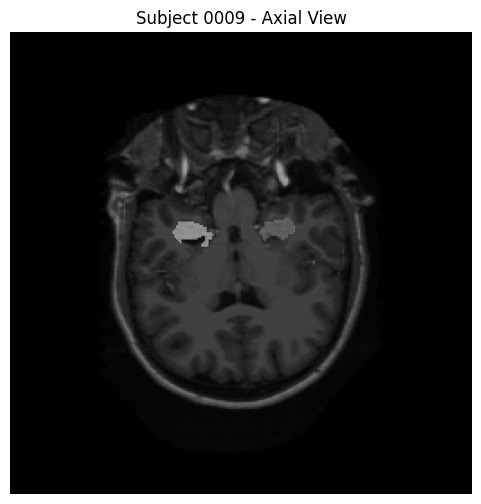

In [16]:
visualize_subject("0009", data_dir="Data_N4", label_dir="Label_fixed")

In [17]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

def compare_n4(before_path, after_path, slice_axis=2):

    img_before = nib.load(before_path).get_fdata()
    img_after = nib.load(after_path).get_fdata()

    idx = img_before.shape[slice_axis] // 2
    if slice_axis == 0:
        slice_before, slice_after = img_before[idx,:,:], img_after[idx,:,:]
    elif slice_axis == 1:
        slice_before, slice_after = img_before[:,idx,:], img_after[:,idx,:]
    else:
        slice_before, slice_after = img_before[:,:,idx], img_after[:,:,idx]

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(np.rot90(slice_before), cmap="gray")
    plt.title("Before N4 correction")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(np.rot90(slice_after), cmap="gray")
    plt.title("After N4 correction")
    plt.axis("off")

    plt.show()

    plt.figure(figsize=(8,5))
    plt.hist(img_before[img_before>0].ravel(), bins=100, alpha=0.5, label="Before N4")
    plt.hist(img_after[img_after>0].ravel(), bins=100, alpha=0.5, label="After N4")
    plt.title("Intensity Histogram")
    plt.xlabel("Intensity")
    plt.ylabel("Voxel Count")
    plt.legend()
    plt.show()


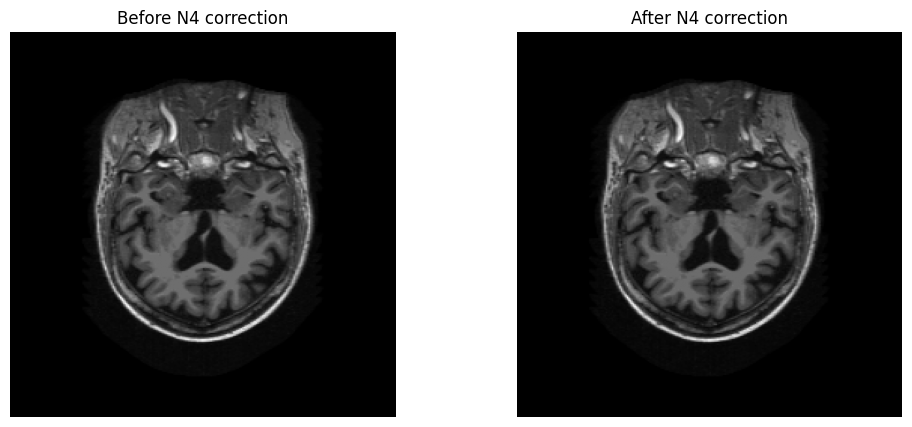

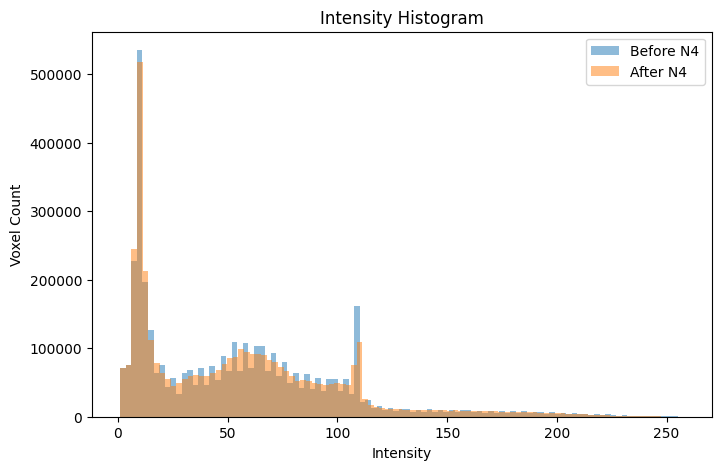

In [18]:
compare_n4("Data_nii/mri_0001.nii", "Data_N4/mri_0001.nii", slice_axis=2)

In [11]:


def zip_and_download(folder_path, zip_name=None):

    if zip_name is None:
        zip_name = folder_path.rstrip("/")

    shutil.make_archive(zip_name, 'zip', folder_path)
    files.download(f"{zip_name}.zip")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
zip_and_download("Data_N4", zip_name="Data_N4")
#zip_and_download("Label_cropped", zip_name="Label_cropped")
zip_and_download("Data_nii", zip_name="Data_nii")